Testing how quantization affects the observed SVD concentration of refusal directions.
Precisions: 4-bit, 8-bit, 16-bit (fp16), 32-bit (fp32)

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import requests
import pandas as pd
import io
import gc
import matplotlib.pyplot as plt
from scipy.linalg import svd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformer_lens import HookedTransformer
from transformers import AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel
from huggingface_hub import login as hf_login
import os
from dotenv import load_dotenv

load_dotenv()
hf_login(token=os.environ.get('HF_TOKEN'))

DEVICE = 'cuda'
LLAMA_PATH = 'meta-llama/Llama-2-7b-chat-hf'
LAT_PATH = 'nlpett/llama-2-7b-chat-hf-LAT-layer4-hh'
AT_PATH = 'nlpett/llama-2-7b-chat-hf-AT-hh'
TEMPLATE = '\n[INST]{prompt}[/INST]\n'

/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-23 12:52:22.462613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attem

In [ ]:
# precision configs - each returns (quantization_config or None, dtype, name)
# Now using string keys to support different quantization variants
PRECISION_CONFIGS = {
    '4bit-nf4': {
        'quant_config': BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        ),
        'dtype': torch.float16,
        'name': '4bit-nf4'
    },
    '4bit-nf4-no-dq': {
        'quant_config': BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=False,
            bnb_4bit_quant_type='nf4'
        ),
        'dtype': torch.float16,
        'name': '4bit-nf4-no-dq'
    },
    '4bit-fp4': {
        'quant_config': BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='fp4'
        ),
        'dtype': torch.float16,
        'name': '4bit-fp4'
    },
    '4bit-nf4-fp32compute': {
        'quant_config': BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float32,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type='nf4'
        ),
        'dtype': torch.float32,
        'name': '4bit-nf4-fp32'
    },
    'bf16': {
        'quant_config': None,
        'dtype': torch.bfloat16,
        'name': 'bf16'
    },
    'fp16': {
        'quant_config': None,
        'dtype': torch.float16,
        'name': 'fp16'
    },
    'fp32': {
        'quant_config': None,
        'dtype': torch.float32,
        'name': 'fp32'
    },
}

def get_precision_config(key):
    if key not in PRECISION_CONFIGS:
        raise ValueError(f'Unknown precision: {key}')
    cfg = PRECISION_CONFIGS[key]
    return cfg['quant_config'], cfg['dtype'], cfg['name']

In [4]:
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

def load_model(peft_path, quant_config, dtype):
    kwargs = {'torch_dtype': dtype, 'device_map': 'auto'}
    if quant_config:
        kwargs['quantization_config'] = quant_config
    
    base = AutoModelForCausalLM.from_pretrained(LLAMA_PATH, **kwargs)
    
    if peft_path:
        peft = PeftModel.from_pretrained(base, peft_path)
        if quant_config is None:
            peft = peft.to(dtype)
        merged = peft.merge_and_unload()
        merged.eval()
        hf_model = merged
        del peft
    else:
        hf_model = base
    
    hooked = HookedTransformer.from_pretrained_no_processing(
        LLAMA_PATH, hf_model=hf_model, dtype=dtype, device=DEVICE, default_padding_side='left'
    )
    hooked.tokenizer.padding_side = 'left'
    hooked.tokenizer.pad_token = '[PAD]'
    
    del base
    if peft_path:
        del hf_model
    clear_gpu()
    return hooked

def unload_model(model):
    del model
    clear_gpu()
    print(f'GPU memory after cleanup: {torch.cuda.memory_allocated()/1e9:.2f} GB')


In [5]:
def get_acts(model, instructions, layer=14, batch_size=16):
    acts = []
    for i in tqdm(range(0, len(instructions), batch_size), desc=f'L{layer}'):
        batch = instructions[i:i+batch_size]
        prompts = [TEMPLATE.format(prompt=p) for p in batch]
        toks = model.tokenizer(prompts, padding=True, return_tensors='pt').input_ids.to(DEVICE)
        with torch.no_grad():
            _, cache = model.run_with_cache(toks, names_filter=lambda n: f'blocks.{layer}.hook_resid_pre' in n)
        acts.append(cache[f'blocks.{layer}.hook_resid_pre'][:, -1, :].cpu())  # move to CPU immediately
        del cache
    return torch.cat(acts, dim=0)

def svd_variance(diffs):
    _, s, _ = svd(diffs.float().numpy(), full_matrices=False)
    v = (s**2) / np.sum(s**2)
    return {'top1': v[0], 'top2': sum(v[:2]), 'top10': sum(v[:10])}

In [6]:
url = 'https://raw.githubusercontent.com/llm-attacks/llm-attacks/main/data/advbench/harmful_behaviors.csv'
harmful_train, _ = train_test_split(
    pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))['goal'].tolist(), 
    test_size=0.2, random_state=42
)

dataset = load_dataset('tatsu-lab/alpaca')
harmless_all = [dataset['train'][i]['instruction'] for i in range(len(dataset['train'])) 
                if dataset['train'][i]['input'].strip() == '']
harmless_train, _ = train_test_split(harmless_all, test_size=0.2, random_state=42)

N = 416
print(f'Using {N} samples each')


Using 416 samples each


In [7]:
# main experiment: iterate precision -> model -> compute SVD
# test multiple 4-bit variants plus bf16/fp16/fp32 bc fp8 isn't supported
PRECISIONS = ['4bit-nf4', '4bit-nf4-no-dq', '4bit-fp4', '4bit-nf4-fp32compute', 'bf16', 'fp16', 'fp32']
MODELS = [('BASE', None), ('AT', AT_PATH), ('LAT', LAT_PATH)]

results = {prec: {} for prec in PRECISIONS}

for prec_key in PRECISIONS:
    quant_config, dtype, prec_name = get_precision_config(prec_key)
    print(f'{prec_name.upper()} PRECISION')
    
    for model_name, peft_path in MODELS:
        print(f'\n{model_name}:')
        
        try:
            model = load_model(peft_path, quant_config, dtype)
            print(f'Loaded. GPU: {torch.cuda.memory_allocated()/1e9:.2f} GB')
            
            harmful_acts = get_acts(model, harmful_train[:N])
            harmless_acts = get_acts(model, harmless_train[:N])
            diffs = harmful_acts - harmless_acts
            
            results[prec_key][model_name] = svd_variance(diffs)
            print(f"{model_name} @ {prec_name}: top-1={results[prec_key][model_name]['top1']*100:.1f}%")
            
            del harmful_acts, harmless_acts, diffs
            unload_model(model)
            
        except Exception as e:
            print(f'ERROR: {e}')
            import traceback
            traceback.print_exc()
            results[prec_key][model_name] = None
            clear_gpu()

`torch_dtype` is deprecated! Use `dtype` instead!


4BIT-NF4 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 4.47 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 11.04it/s]


BASE @ 4bit-nf4: top-1=48.8%
GPU memory after cleanup: 4.51 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.15s/it]
/home/ubuntu/.local/lib/python3.10/site-packages/peft/tuners/lora/bnb.py:397: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.57 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 10.79it/s]


AT @ 4bit-nf4: top-1=43.1%
GPU memory after cleanup: 4.51 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.57 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 10.79it/s]


LAT @ 4bit-nf4: top-1=51.0%
GPU memory after cleanup: 4.51 GB
4BIT-NF4-NO-DQ PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.89 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 12.63it/s]


BASE @ 4bit-nf4-no-dq: top-1=48.8%
GPU memory after cleanup: 4.83 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 8.19 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 12.47it/s]


AT @ 4bit-nf4-no-dq: top-1=43.1%
GPU memory after cleanup: 4.83 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 8.19 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 12.65it/s]


LAT @ 4bit-nf4-no-dq: top-1=50.0%
GPU memory after cleanup: 4.83 GB
4BIT-FP4 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.86 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 10.98it/s]


BASE @ 4bit-fp4: top-1=51.1%
GPU memory after cleanup: 4.51 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.57 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 10.84it/s]


AT @ 4bit-fp4: top-1=46.2%
GPU memory after cleanup: 4.51 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 7.58 GB


L14: 100%|██████████| 26/26 [00:02<00:00, 10.81it/s]


LAT @ 4bit-fp4: top-1=37.7%
GPU memory after cleanup: 4.51 GB
4BIT-NF4-FP32 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 8.19 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]


BASE @ 4bit-nf4-fp32: top-1=48.9%
GPU memory after cleanup: 5.12 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 8.20 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  5.13it/s]


AT @ 4bit-nf4-fp32: top-1=43.1%
GPU memory after cleanup: 5.13 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 8.20 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  5.12it/s]


LAT @ 4bit-nf4-fp32: top-1=50.9%
GPU memory after cleanup: 5.13 GB
BF16 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 17.19 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 16.98it/s]


BASE @ bf16: top-1=50.5%
GPU memory after cleanup: 14.12 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 14.12 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 17.29it/s]


AT @ bf16: top-1=37.6%
GPU memory after cleanup: 14.12 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 14.12 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 17.30it/s]


LAT @ bf16: top-1=99.2%
GPU memory after cleanup: 14.12 GB
FP16 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 14.12 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 17.26it/s]


BASE @ fp16: top-1=50.5%
GPU memory after cleanup: 14.12 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 14.12 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 17.51it/s]


AT @ fp16: top-1=37.6%
GPU memory after cleanup: 14.12 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 14.12 GB


L14: 100%|██████████| 26/26 [00:01<00:00, 17.39it/s]


LAT @ fp16: top-1=99.2%
GPU memory after cleanup: 14.12 GB
FP32 PRECISION

BASE:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 27.66 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


BASE @ fp32: top-1=50.5%
GPU memory after cleanup: 27.66 GB

AT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 27.66 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  4.80it/s]


AT @ fp32: top-1=37.6%
GPU memory after cleanup: 27.66 GB

LAT:


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Loaded. GPU: 27.66 GB


L14: 100%|██████████| 26/26 [00:05<00:00,  4.79it/s]


LAT @ fp32: top-1=99.2%
GPU memory after cleanup: 27.66 GB


In [21]:
print(f"{'Precision':<20} {'BASE':>9} {'AT':>8} {'LAT':>8}")
print("-" * 52)
for prec_key in PRECISIONS:
    _, _, prec_name = get_precision_config(prec_key)
    row = f"{prec_name:<20}"
    for model_name in ['BASE', 'AT', 'LAT']:
        if results[prec_key].get(model_name):
            row += f"{results[prec_key][model_name]['top1']*100:>10.1f}"
        else:
            row += f"{'N/A':>10}"
    print(row)


Precision                 BASE       AT      LAT
----------------------------------------------------
4bit-nf4                  48.8      43.1      51.0
4bit-nf4-no-dq            48.8      43.1      50.0
4bit-fp4                  51.1      46.2      37.7
4bit-nf4-fp32             48.9      43.1      50.9
bf16                      50.5      37.6      99.2
fp16                      50.5      37.6      99.2
fp32                      50.5      37.6      99.2


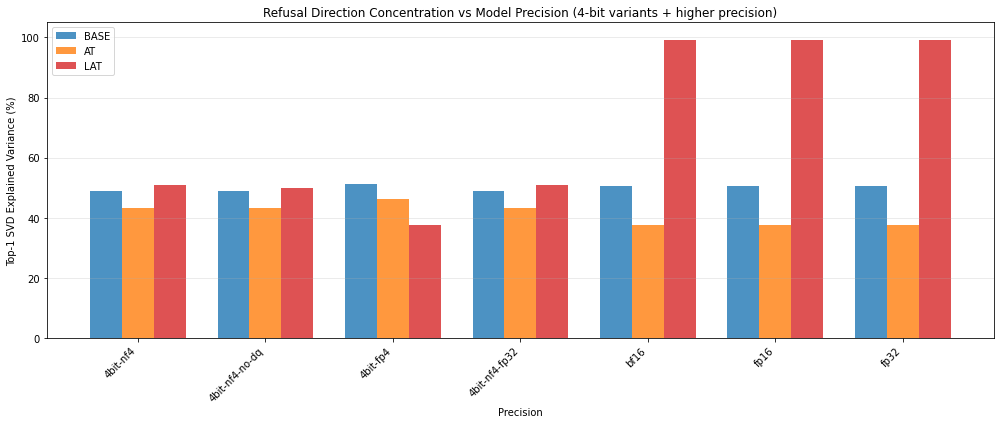

In [25]:
fig, ax = plt.subplots(figsize=(14, 6), facecolor='white')
ax.set_facecolor('white')

prec_labels = [get_precision_config(p)[2] for p in PRECISIONS]
x = np.arange(len(PRECISIONS))
width = 0.25

colors = {'BASE': 'tab:blue', 'AT': 'tab:orange', 'LAT': 'tab:red'}

for i, model_name in enumerate(['BASE', 'AT', 'LAT']):
    vals = []
    for prec_key in PRECISIONS:
        if results[prec_key].get(model_name):
            vals.append(results[prec_key][model_name]['top1'] * 100)
        else:
            vals.append(0)
    ax.bar(x + (i - 1) * width, vals, width, label=model_name, color=colors[model_name], alpha=0.8)

ax.set_xlabel('Precision')
ax.set_ylabel('Top-1 SVD Explained Variance (%)')
ax.set_title('Refusal Direction Concentration vs Model Precision (4-bit variants + higher precision)')
ax.set_xticks(x)
ax.set_xticklabels(prec_labels, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

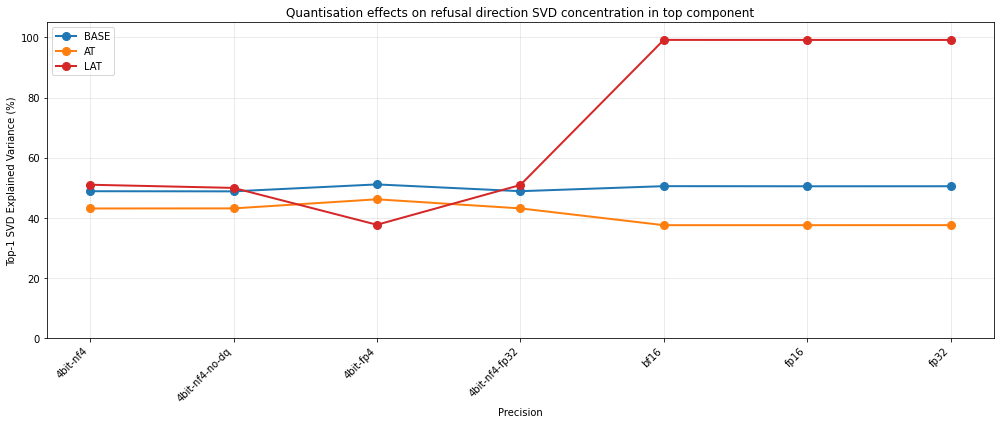

In [26]:
# line plot version - concentration trend
fig, ax = plt.subplots(figsize=(14, 6), facecolor='white')
ax.set_facecolor('white')

prec_labels = [get_precision_config(p)[2] for p in PRECISIONS]

for model_name in ['BASE', 'AT', 'LAT']:
    vals = []
    for prec_key in PRECISIONS:
        if results[prec_key].get(model_name):
            vals.append(results[prec_key][model_name]['top1'] * 100)
        else:
            vals.append(np.nan)
    ax.plot(prec_labels, vals, 'o-', label=model_name, color=colors[model_name], linewidth=2, markersize=8)

ax.set_xlabel('Precision')
ax.set_ylabel('Top-1 SVD Explained Variance (%)')
ax.set_title('Quantisation effects on refusal direction SVD concentration in top component')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 105)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()